#📌 Extracción

In [28]:
# Importación y configuración Librerías
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo gráfico (opcional)
sns.set(style="whitegrid")

# Parámetros
URL = "https://raw.githubusercontent.com/NellyCN/TelecomX_LATAM/refs/heads/main/data/TelecomX_Data.json"

# Utilidad para guardar gráficos
from pathlib import Path
OUTPUTS_DIR = Path("outputs")
OUTPUTS_DIR.mkdir(exist_ok=True)

#🔧 Transformación

In [29]:
# Descarga
resp = requests.get(URL)
resp.raise_for_status()
data = resp.json()  # lista de dicts

# Normalizar JSON anidado a columnas planas
df = pd.json_normalize(data, sep=".")

print(f"Filas: {len(df):,} | Columnas: {df.shape[1]}")
df.head()

Filas: 7,267 | Columnas: 21


,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


In [31]:
# Visualización general
df.info()

# Tipos esperados: cargos deben ser numéricos
cols_num = ["account.Charges.Monthly", "account.Charges.Total"]
for c in cols_num:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Churn solo 'Yes'/'No' (eliminar vacíos o raros)
if "Churn" in df.columns:
    df["Churn"] = df["Churn"].astype(str).str.strip()
    df = df[df["Churn"].isin(["Yes", "No"])]

# Rellenar nulos lógicos en Total (clientes nuevos sin acumulado)
if "account.Charges.Total" in df.columns:
    df["account.Charges.Total"] = df["account.Charges.Total"].fillna(0)

# Variables categóricas más usadas → category
cat_candidates = [
    "Churn",
    "customer.gender",
    "customer.Partner",
    "customer.Dependents",
    "phone.PhoneService",
    "phone.MultipleLines",
    "internet.InternetService",
    "internet.OnlineSecurity",
    "internet.OnlineBackup",
    "internet.DeviceProtection",
    "internet.TechSupport",
    "internet.StreamingTV",
    "internet.StreamingMovies",
    "account.Contract",
    "account.PaperlessBilling",
    "account.PaymentMethod",
]
for c in cat_candidates:
    if c in df.columns:
        df[c] = df[c].astype("category")

# Numéricas obvias
num_candidates = ["customer.SeniorCitizen", "customer.tenure"]
for c in num_candidates:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Quitar duplicados obvios por customerID (si existieran)
if "customerID" in df.columns:
    antes = len(df)
    df = df.drop_duplicates(subset=["customerID"])
    despues = len(df)
    print(f"Duplicados eliminados: {antes - despues}")

# Check final
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   customerID                 7043 non-null   object  
 1   Churn                      7043 non-null   category
 2   customer.gender            7043 non-null   category
 3   customer.SeniorCitizen     7043 non-null   int64   
 4   customer.Partner           7043 non-null   category
 5   customer.Dependents        7043 non-null   category
 6   customer.tenure            7043 non-null   int64   
 7   phone.PhoneService         7043 non-null   category
 8   phone.MultipleLines        7043 non-null   category
 9   internet.InternetService   7043 non-null   category
 10  internet.OnlineSecurity    7043 non-null   category
 11  internet.OnlineBackup      7043 non-null   category
 12  internet.DeviceProtection  7043 non-null   category
 13  internet.TechSupport       7043 non-nu

# 📊 Carga y análisis

In [33]:
# Control de calidad (nulos, únicos, rangos)
print("Nulos por columna:")
print(df.isnull().sum().sort_values(ascending=False).head(20))

print("\nDistribución de 'Churn':")
print(df["Churn"].value_counts(dropna=False))

# Valores únicos en categóricas (muestra resumida)
print("\nValores únicos por columna categórica:")
for c in df.select_dtypes(include=["category"]).columns:
    uniques = df[c].unique()
    print(f"- {c}: {len(uniques)} únicos -> {list(uniques)[:8]}{'...' if len(uniques)>8 else ''}")

# Descriptivo de numéricas
print("\nResumen numéricas:")
print(df.select_dtypes(include=[np.number]).describe().T)


Nulos por columna:
customerID                   0
Churn                        0
customer.gender              0
customer.SeniorCitizen       0
customer.Partner             0
customer.Dependents          0
customer.tenure              0
phone.PhoneService           0
phone.MultipleLines          0
internet.InternetService     0
internet.OnlineSecurity      0
internet.OnlineBackup        0
internet.DeviceProtection    0
internet.TechSupport         0
internet.StreamingTV         0
internet.StreamingMovies     0
account.Contract             0
account.PaperlessBilling     0
account.PaymentMethod        0
account.Charges.Monthly      0
dtype: int64

Distribución de 'Churn':
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Valores únicos por columna categórica:
- Churn: 2 únicos -> ['No', 'Yes']
- customer.gender: 2 únicos -> ['Female', 'Male']
- customer.Partner: 2 únicos -> ['Yes', 'No']
- customer.Dependents: 2 únicos -> ['Yes', 'No']
- phone.PhoneService: 2 únicos -> ['Yes', 'No'

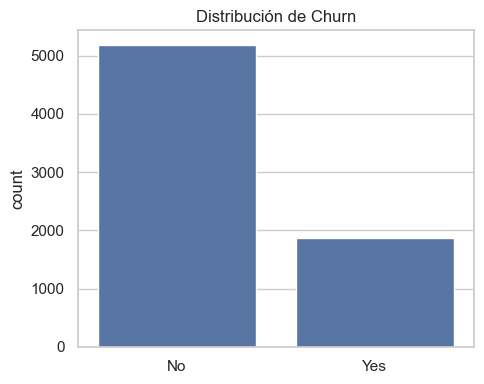

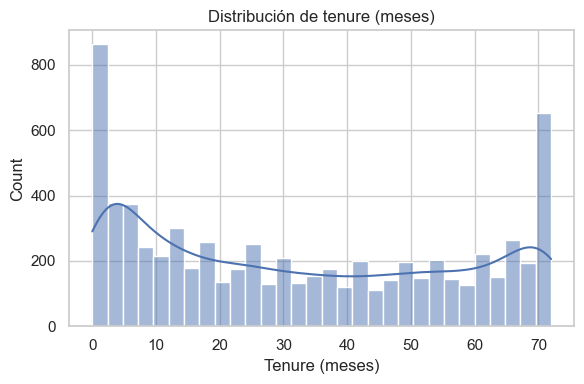

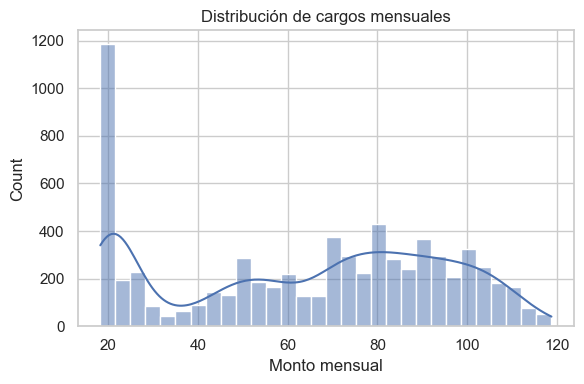

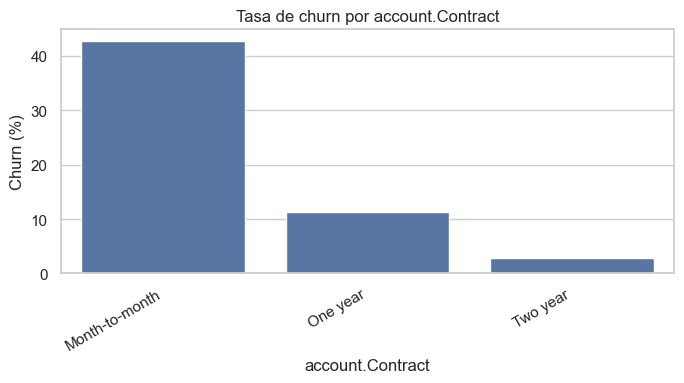

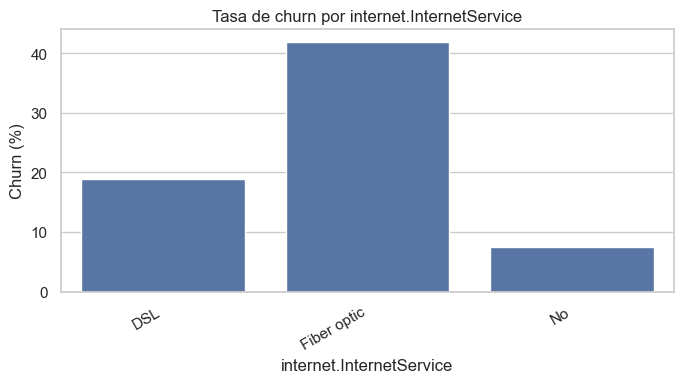

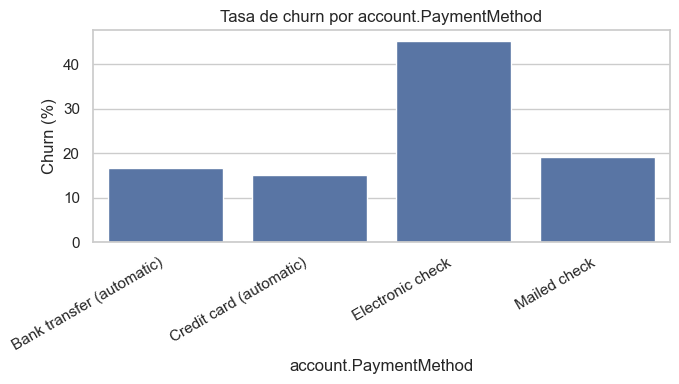

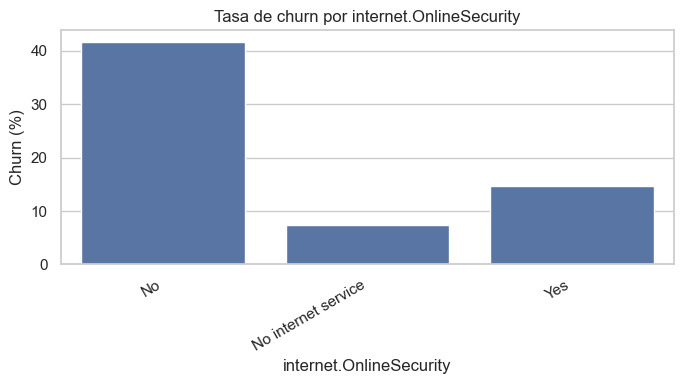

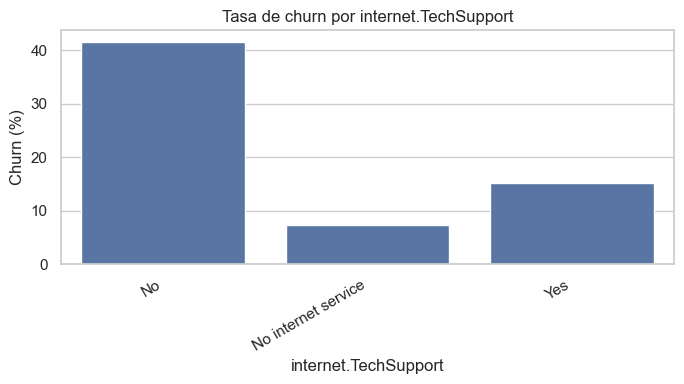

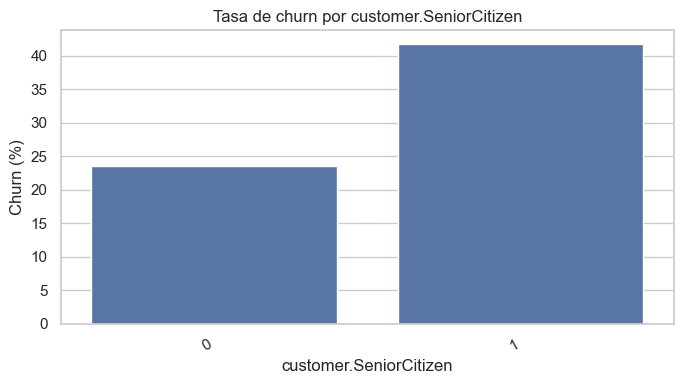

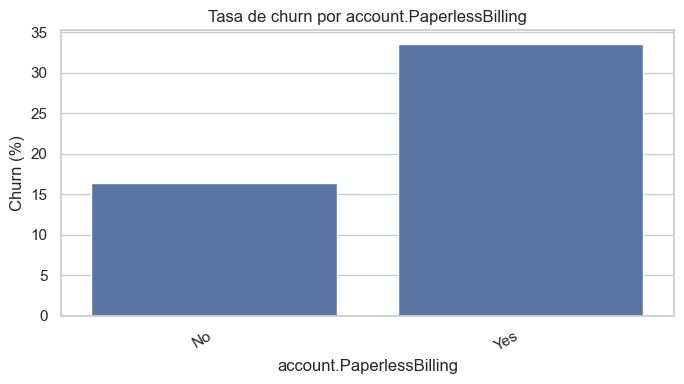

In [34]:
# Distribución de Churn
plt.figure(figsize=(5,4))
sns.countplot(data=df, x="Churn")
plt.title("Distribución de Churn")
plt.xlabel("")
plt.tight_layout()
plt.savefig(OUTPUTS_DIR / "dist_churn.png", dpi=150)
plt.show()

# Tenure (meses con la compañía)
if "customer.tenure" in df.columns:
    plt.figure(figsize=(6,4))
    sns.histplot(data=df, x="customer.tenure", bins=30, kde=True)
    plt.title("Distribución de tenure (meses)")
    plt.xlabel("Tenure (meses)")
    plt.tight_layout()
    plt.savefig(OUTPUTS_DIR / "dist_tenure.png", dpi=150)
    plt.show()

# Cargos mensuales
if "account.Charges.Monthly" in df.columns:
    plt.figure(figsize=(6,4))
    sns.histplot(data=df, x="account.Charges.Monthly", bins=30, kde=True)
    plt.title("Distribución de cargos mensuales")
    plt.xlabel("Monto mensual")
    plt.tight_layout()
    plt.savefig(OUTPUTS_DIR / "dist_monthly.png", dpi=150)
    plt.show()

# Tasa de churn por categoría (función utilitaria)
def plot_churn_rate_by(col):
    if col not in df.columns:
        print(f"Columna no encontrada: {col}")
        return
    tmp = (
        df.groupby(col, observed=False)["Churn"]
        .apply(lambda s: (s == "Yes").mean()*100)
        .reset_index(name="ChurnRate_%")
        .sort_values("ChurnRate_%", ascending=False)
    )
    plt.figure(figsize=(7,4))
    sns.barplot(data=tmp, x=col, y="ChurnRate_%")
    plt.title(f"Tasa de churn por {col}")
    plt.xticks(rotation=30, ha="right")
    plt.ylabel("Churn (%)")
    plt.tight_layout()
    fname = f"churn_rate_by_{col.replace('.','_')}.png"
    plt.savefig(OUTPUTS_DIR / fname, dpi=150)
    plt.show()
    return tmp

# Churn por variables de negocio relevantes
tab_contract = plot_churn_rate_by("account.Contract")
tab_internet = plot_churn_rate_by("internet.InternetService")
tab_payment  = plot_churn_rate_by("account.PaymentMethod")
tab_security = plot_churn_rate_by("internet.OnlineSecurity")
tab_techsup  = plot_churn_rate_by("internet.TechSupport")

# Churn por SeniorCitizen y PaperlessBilling
tab_senior = plot_churn_rate_by("customer.SeniorCitizen")
tab_paper  = plot_churn_rate_by("account.PaperlessBilling")


🔹 Tasa global de cancelación:
   El 26.54% de los clientes abandonaron el servicio.

🔹 Cancelación por tipo de contrato:
   - Month-to-month: 42.71%
   - One year: 11.27%
   - Two year: 2.83%

🔹 Cancelación por servicio de internet:
   - DSL: 18.96%
   - Fiber optic: 41.89%
   - No: 7.40%

🔹 Factores relacionados con la cancelación:
   - account.Charges.Monthly: 0.193356422237847
   - account.Charges.Total: -0.1983242626039952
   - internet.TechSupport_bin: -0.274421815657971
   - internet.OnlineSecurity_bin: -0.28081637309329394
   - customer.tenure: -0.3522286701130792


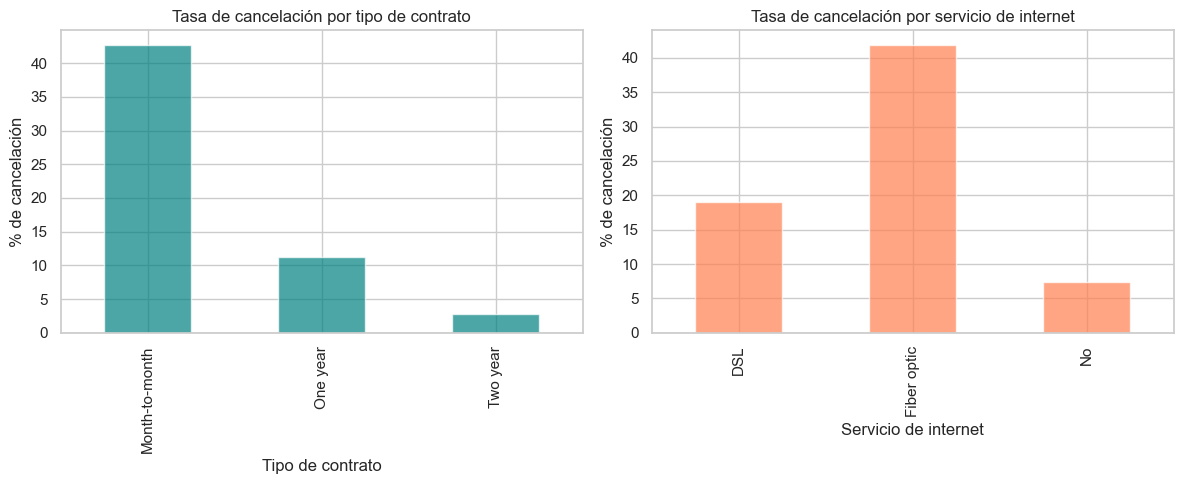

In [35]:
# Métricas y cruces(insights cuantitativos)
insights = {}

# Churn global
churn_global = round((df["Churn"]=="Yes").mean()*100, 2)
insights["Tasa global de cancelación"] = f"El {churn_global}% de los clientes abandonaron el servicio."

# Churn por contrato
if "account.Contract" in df.columns:
    churn_contrato = (
        df.groupby("account.Contract", observed=True)["Churn"]
          .apply(lambda s: (s=="Yes").mean()*100)
          .to_dict()
    )
    insights["Cancelación por tipo de contrato"] = {
        k: f"{v:.2f}%" for k, v in churn_contrato.items()
    }

# Churn por tipo de internet
if "internet.InternetService" in df.columns:
    churn_internet = (
        df.groupby("internet.InternetService", observed=True)["Churn"]
          .apply(lambda s: (s=="Yes").mean()*100)
          .to_dict()
    )
    insights["Cancelación por servicio de internet"] = {
        k: f"{v:.2f}%" for k, v in churn_internet.items()
    }

# Correlación simple (codificando Yes/No)
df_num = df.copy()
df_num["Churn_bin"] = (df_num["Churn"]=="Yes").astype(int)

for c in ["internet.OnlineSecurity", "internet.TechSupport", "account.PaperlessBilling"]:
    if c in df_num.columns:
        df_num[c+"_bin"] = df_num[c].map({"Yes":1, "No":0})

corr_cols = [
    "Churn_bin", "customer.tenure", 
    "account.Charges.Monthly", "account.Charges.Total"
] + [c+"_bin" for c in ["internet.OnlineSecurity", "internet.TechSupport", "account.PaperlessBilling"] if c+"_bin" in df_num.columns]

corr = df_num[corr_cols].corr(numeric_only=True)["Churn_bin"].sort_values(ascending=False)
insights["Factores relacionados con la cancelación"] = corr.drop("Churn_bin").to_dict()

# Mostrar los insights de forma más amigable
for k, v in insights.items():
    print(f"\n🔹 {k}:")
    if isinstance(v, dict):
        for subk, subv in v.items():
            print(f"   - {subk}: {subv}")
    else:
        print(f"   {v}")

# 📊 Gráfico explicativo de churn por contrato e internet
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Gráfico churn por contrato
pd.Series(churn_contrato).plot(kind="bar", ax=axes[0], color="teal", alpha=0.7)
axes[0].set_title("Tasa de cancelación por tipo de contrato")
axes[0].set_ylabel("% de cancelación")
axes[0].set_xlabel("Tipo de contrato")

# Gráfico churn por servicio de internet
pd.Series(churn_internet).plot(kind="bar", ax=axes[1], color="coral", alpha=0.7)
axes[1].set_title("Tasa de cancelación por servicio de internet")
axes[1].set_ylabel("% de cancelación")
axes[1].set_xlabel("Servicio de internet")

plt.tight_layout()
plt.show()

#📄Informe final

## Informe — Telecom X (Churn)

### 1. Introducción
El objetivo de este análisis es identificar factores asociados a la cancelación de clientes (Churn) en Telecom X para apoyar estrategias de retención.

### 2. Limpieza y Tratamiento de Datos (ETL)
- Se cargó el JSON desde la URL pública (raw GitHub).
- Se normalizó la estructura anidada (`customer`, `phone`, `internet`, `account`) a columnas planas con `pd.json_normalize`.
- Se convirtieron a numéricos: `account.Charges.Monthly`, `account.Charges.Total`. Los nulos en `Total` se imputaron con 0 (clientes nuevos sin acumulado).
- Se filtró `Churn` a valores válidos {Yes, No} y se tiparon columnas categóricas de negocio.

### 3. Análisis Exploratorio (EDA)
- **Churn global:** (ver celda de métricas).
![alt text](outputs/dist_churn.png)

- **Mayor churn** en clientes con contrato **Month-to-month** frente a contratos **One year**/**Two year**.
![alt text](6e45064d-e372-400f-9b77-9e832fe3ac14.png)

- **Servicios de seguridad/soporte** (`OnlineSecurity`, `TechSupport`) se asocian con **menor churn**.

- **Tenure** bajo (clientes recientes) presenta más churn; se estabiliza con mayor antigüedad.
![alt text](outputs/dist_tenure.png)

- **PaperlessBilling** puede mostrar diferencias; revisar junto a método de pago.


### 4. Conclusiones e Insights
- El **tipo de contrato** es un driver clave: contratos mensuales concentran la mayor tasa de churn.
- La **adopción de servicios de valor** (seguridad en línea y soporte técnico) se relaciona con **retención**.
- **Antigüedad (tenure)** es protectora: clientes más antiguos desertan menos.
- **Cargos**: revisar si niveles altos de cargos mensuales impactan en churn en combinación con tipo de servicio.

### 5. Recomendaciones
- **Incentivar upgrades de contrato** (descuentos a 12/24 meses, bundles).
- **Promover paquetes con precio preferente** de `OnlineSecurity` y `TechSupport`.
- **Onboarding reforzado** para clientes nuevos (<6 meses): contacto proactivo y ofertas personalizadas.
- **Revisar fricción de pago**: evaluar impacto por método y paperless, diseñar nudges de recordatorio/pago.
- **Segmentación**: modelos predictivos de churn usando variables comportamentales + servicios contratados.
